# Модель МО для восстановления золота из золотосодержащей руды.

Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
Вам нужно:

  - Подготовить данные
  - Провести исследовательский анализ данных;
  - Построить и обучить модель.


Опишем каждую стадию:
1. Флотация
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Наименование признаков

Наименование признаков должно быть такое:
- [этап].[тип_параметра].[название_параметра] <br>
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
    
    rougher — флотация
    primary_cleaner — первичная очистка
    secondary_cleaner — вторичная очистка
    final — финальные характеристики

Возможные значения для блока [тип_параметра]:

    input — параметры сырья
    output — параметры продукта
    state — параметры, характеризующие текущее состояние этапа
    calculation — расчётные характеристики

## Расчет эффективности
Эффективность обогащения рассчитывается по формуле:

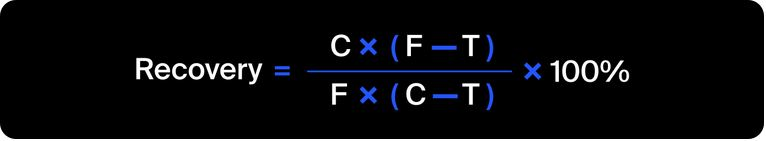

где:

    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

## Метрики качества

Нужно спрогнозировать сразу две величины:

    эффективность обогащения чернового концентрата rougher.output.recovery;
    эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

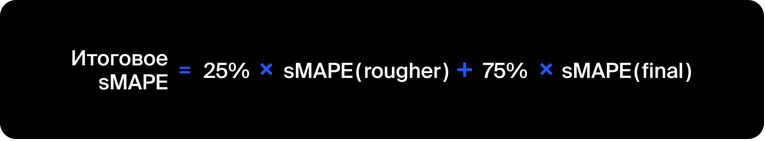

## Описание данных

Технологический [процесс]:

    Rougher feed — исходное сырье
    Rougher additions (или reagent additions) — флотационные реагенты:
    Xanthate **— ксантогенат (промотер, или активатор флотации)
    Sulphate — сульфат (на данном производстве сульфид натрия)
    Depressant — депрессант (силикат натрия).
    Rougher process (англ. «грубый процесс») — флотация
    Rougher tails — отвальные хвосты
    Float banks — флотационная установка
    Cleaner process — очистка
    Rougher Au — черновой концентрат золота
    Final Au — финальный концентрат золота

Параметры [этапов]:

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи

In [1]:
pip install -U numpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.5 MB 36 kB/s  eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.5 MB 9.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U sklearn

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=9f48b75210fc777f77777b34d51a8b43cab8ee7ef1095fdc7cfebf66418a1d5b
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.6 MB 7.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 283 kB 846 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# 1. Подготовка данных

#### 1.1. Откройте файлы и изучите их.<br>

**Ответ:**

В данных имеются пропуски, количество столбцов в файлах не одинаково.

In [6]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')

In [7]:
print(df_full.info(), end='\n')
print(df_test.info(), end='\n')
print(df_train.info(), end='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


#### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.<br>

**Ответ:**

Значение MAE близко к нулю, можно сделать заключение, что значение rougher.output.recovery рассчитано правильно.

In [8]:
# C — доля золота в концентрате после флотации
# F — доля золота в сырье/концентрате до флотации/очистки
# T — доля золота в отвальных хвостах после флотации/очистки

def recovery(C, F, T):
    recovery = ((C*(F-T)) / (F*(C-T)))
    return recovery*100

df_train['rougher.output.recovery_control'] = recovery(
    df_train['rougher.output.concentrate_au'],
    df_train['rougher.input.feed_au'],
    df_train['rougher.output.tail_au'])

x = df_train['rougher.output.recovery']
y = df_train['rougher.output.recovery_control']
mae = (x - y).abs().mean()
print(f'mae - {mae :.2f}')

mae - 0.00


#### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?<br>

**Ответ:**

Можно утверждать, что из df_test исключили целевые столбцы, оставив только признаковые.

In [9]:
df_col = df_train.drop(df_test.columns, axis=1)
df_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 35 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                                16794 non-null  float64


#### 1.4. Проведите предобработку данных. <br>

**Ответ:**

Отсутствующие значения заполним ближайшими, по условию задачи.    

In [10]:
df_full = df_full.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_train = df_train.fillna(method='ffill')

df_full['date'] = pd.to_datetime(df_full['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

# Проверяем.
print(df_full.info(), end='\n')
print(df_test.info(), end='\n')
print(df_train.info(), end='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22716 non-null  float64       
 2   final.output.concentrate_pb                         22716 non-null  float64       
 3   final.output.concentrate_sol                        22716 non-null  float64       
 4   final.output.concentrate_au                         22716 non-null  float64       
 5   final.output.recovery                               22716 non-null  float64       
 6   final.output.tail_ag                                22716 non-null  float64       
 7   final.output.tail_pb                                22716 non-null  float64       
 8   final.

# 2. Анализ данных

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

**Ответ:**

Как видно по среднему содержанию сырья от этапа к этапу увеличивается концентрация золота. Мы видим, что в финальном концентрате доля свинца больше, чем доля серебра, можно заключить, что очистить руду от свинца сложнее, чем от серебра.<br>


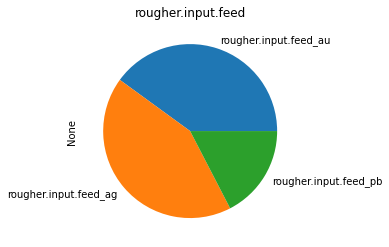

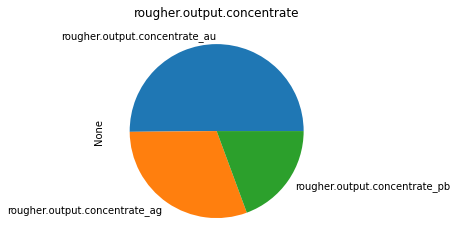

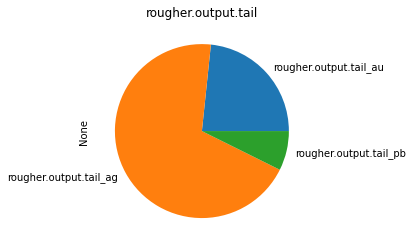

In [11]:
def construct_pie(df, title):
    df.mean().plot.pie()
    plt.title(title)
    plt.show()

# rougher
construct_pie(df_full[['rougher.input.feed_au' ,'rougher.input.feed_ag', 'rougher.input.feed_pb']], 'rougher.input.feed')
construct_pie(df_full[['rougher.output.concentrate_au' ,'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']], 'rougher.output.concentrate')
construct_pie(df_full[['rougher.output.tail_au' ,'rougher.output.tail_ag', 'rougher.output.tail_pb']], 'rougher.output.tail')

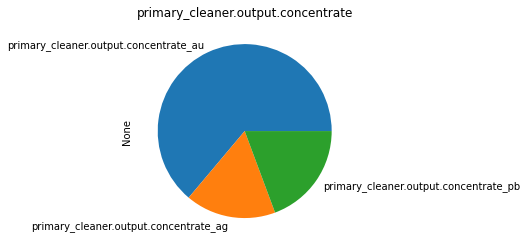

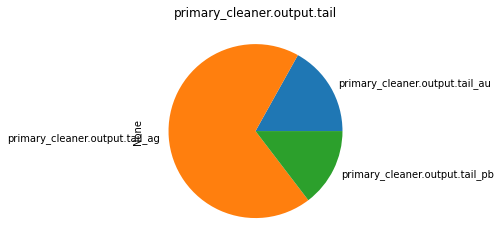

In [12]:
# primary_cleaner
construct_pie(df_full[['primary_cleaner.output.concentrate_au' ,'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb']], 'primary_cleaner.output.concentrate')
construct_pie(df_full[['primary_cleaner.output.tail_au' ,'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb']], 'primary_cleaner.output.tail')

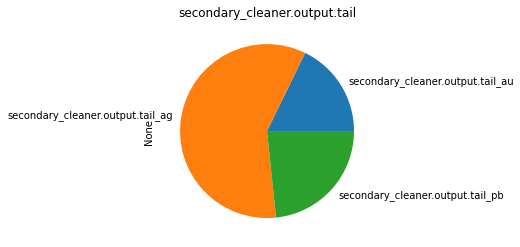

In [13]:
# secondary_cleaner
construct_pie(df_full[['secondary_cleaner.output.tail_au' ,'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb']], 'secondary_cleaner.output.tail')

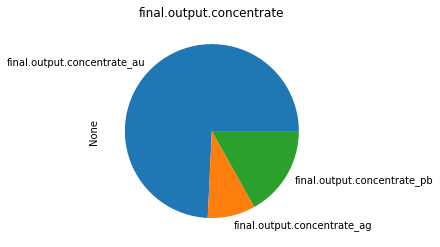

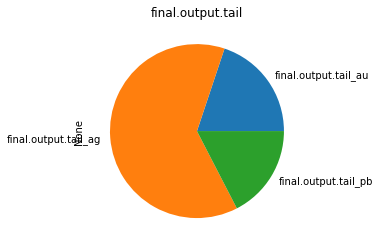

In [14]:
# final
construct_pie(df_full[['final.output.concentrate_au' ,'final.output.concentrate_ag', 'final.output.concentrate_pb']], 'final.output.concentrate')
construct_pie(df_full[['final.output.tail_au' ,'final.output.tail_ag', 'final.output.tail_pb']], 'final.output.tail')

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

**Ответ:**

Распределение весьма похоже в тестовой и обучающей. Но можно увидеть, что имеется огромное количество выбросов.

<AxesSubplot:>

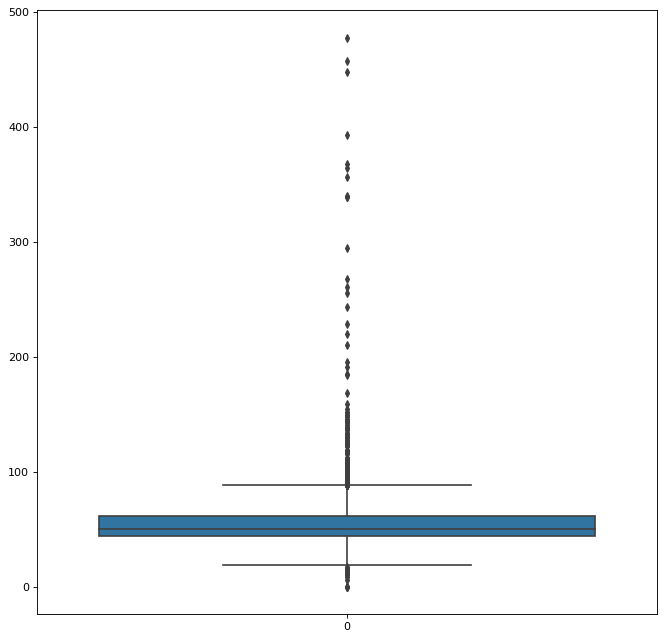

In [15]:
plt.figure(figsize=(10,10), dpi= 80)
sns.boxplot(data=df_test['rougher.input.feed_size'])

<AxesSubplot:>

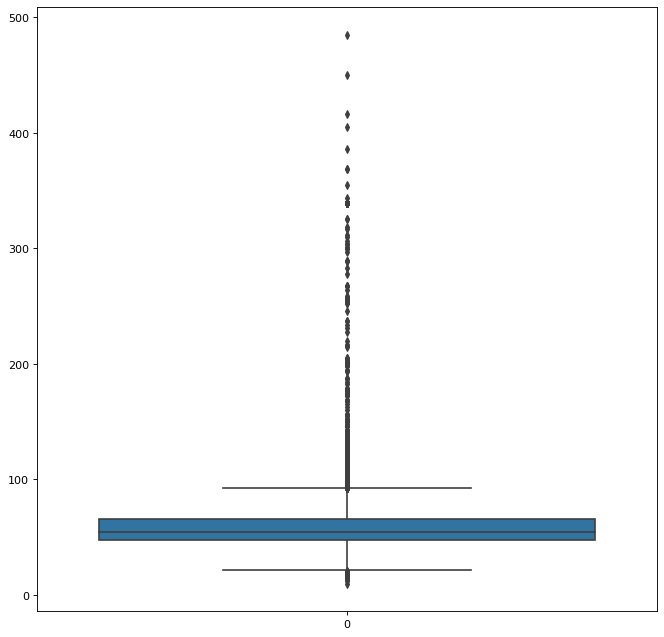

In [16]:
plt.figure(figsize=(10,10), dpi= 80)
sns.boxplot(data=df_train['rougher.input.feed_size'])

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

**Ответ:**

Выбросы найдены и удалены.

In [17]:
# Подготовим данные для визуализации.

final = df_full.iloc[:, 1:10]
final = final.drop(final.columns[4], axis=1)

primary_cleaner = df_full.iloc[:, 14:22]

rougher = df_full.iloc[:, 34:53]
rougher = rougher.drop(rougher.columns[[2,3,6,7,8,9,14]], axis=1)

secondary_cleaner = df_full.iloc[:, 65:69]
secondary_cleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   secondary_cleaner.output.tail_ag   22716 non-null  float64
 1   secondary_cleaner.output.tail_pb   22716 non-null  float64
 2   secondary_cleaner.output.tail_sol  22716 non-null  float64
 3   secondary_cleaner.output.tail_au   22716 non-null  float64
dtypes: float64(4)
memory usage: 710.0 KB


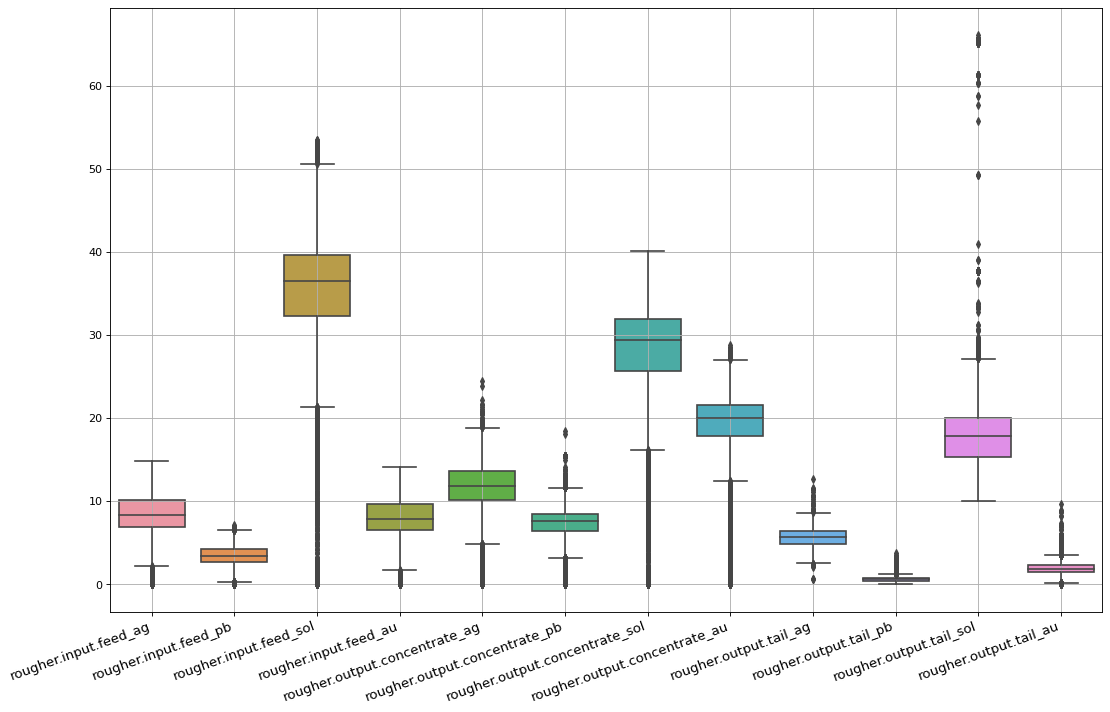

In [18]:
def construct_boxplot(df, m):

    plt.figure(figsize=(m,10), dpi= 80)
    sns.boxplot(data=df)
    plt.xticks(rotation=20, horizontalalignment='right', fontsize=12)
    plt.grid()
    plt.show()

construct_boxplot(rougher, 16)

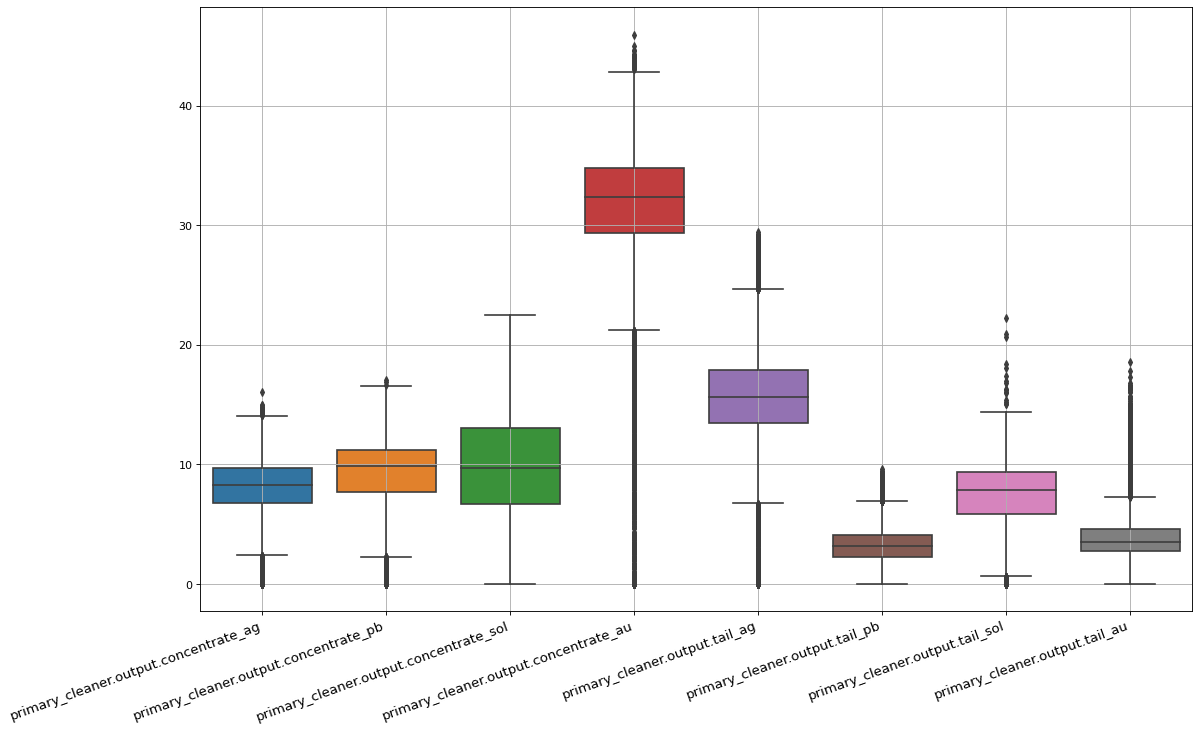

In [19]:
construct_boxplot(primary_cleaner, 16)

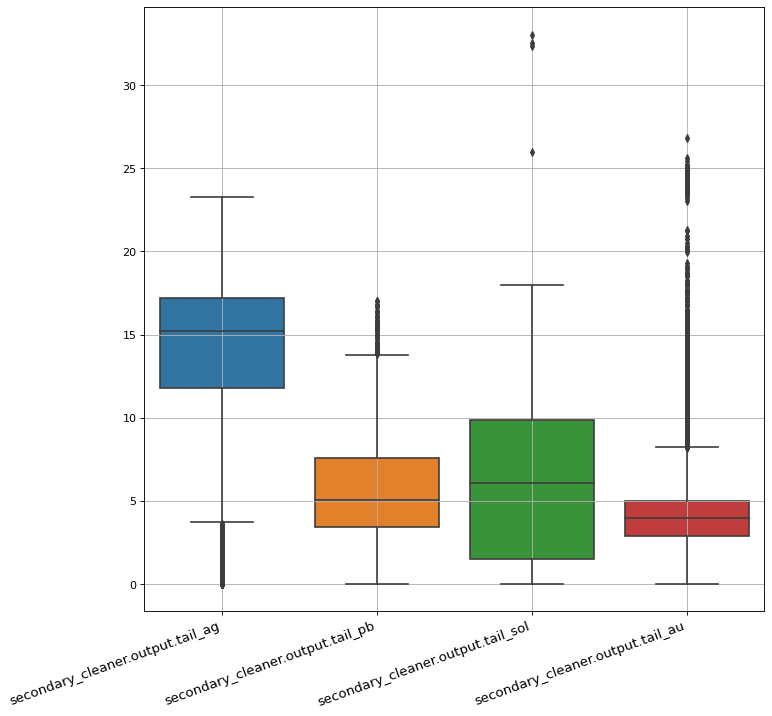

In [20]:
construct_boxplot(secondary_cleaner, 10)

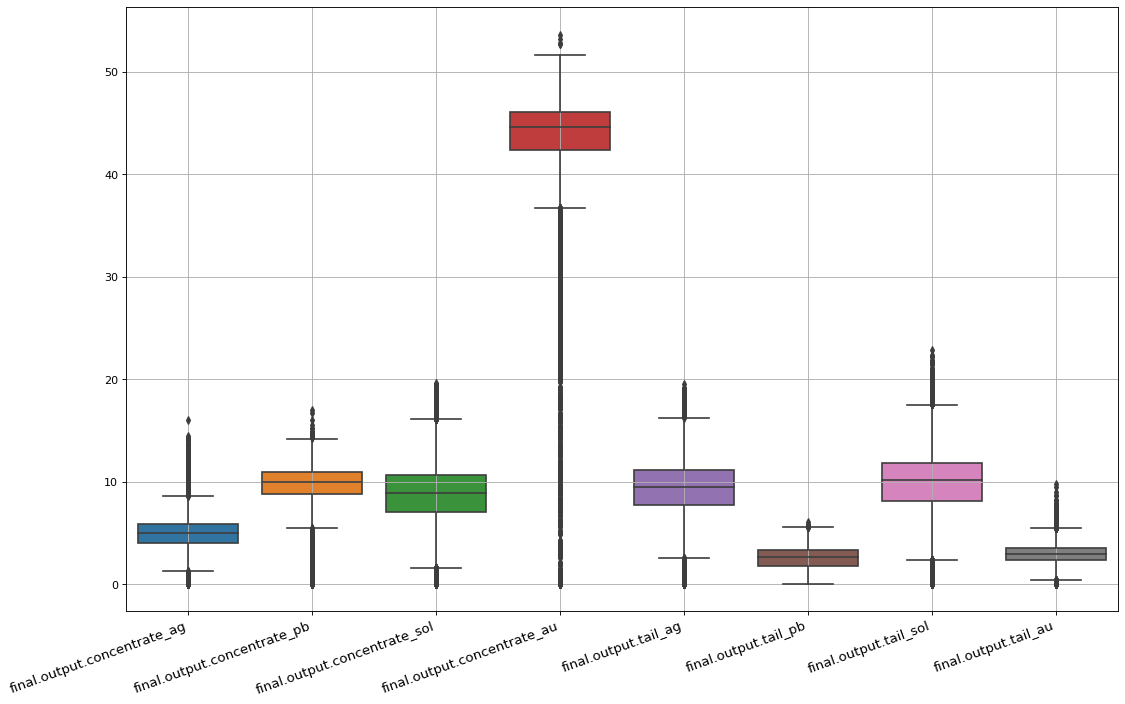

In [21]:
construct_boxplot(final, 16)

In [22]:
# Проведём винсоризацию выбросов. Это будет лучше, чем удаление.

df_train_wins = df_train.drop(['date', 'rougher.output.recovery_control'], axis=1)

for i in df_train_wins.columns:
    df_train_wins[i] = pd.Series(winsorize(df_train_wins[i], limits=[0.05, 0.05]))

# 3. Модель

3.1. Напишите функцию для вычисления итоговой sMAPE.

**Ответ:**

Готово.

In [23]:
def smape(y_true, y_pred):
    first = np.abs(y_true - y_pred)
    second = (np.abs(y_true) + np.abs(y_pred)) / 2
    result = np.mean(first / second)
    return result


def smape_result(y_true, y_pred):
    rougher = smape(y_true[0], y_pred[0])
    final = smape(y_true[1], y_pred[1])
    smape_result = 0.25 * rougher + 0.75 * final
    return smape_result


3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

**Ответ:**

Модель обучена с подбором параметров. Целевая метрика примерно равна нулю, это хорошо. Как и крос-валидация показывает хорошие результаты.

In [37]:
my_scorer = make_scorer(smape_result, greater_is_better=False)


features = df_train_wins[df_test.columns[1:]]
target = df_train_wins[['rougher.output.recovery', 'final.output.recovery']].to_numpy()
test = df_test.drop('date', axis=1).to_numpy()


features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12)


params = {
    'fit_intercept' : [True, False],
    'normalize': [True, False]
    }


model = LinearRegression()


model_cv = GridSearchCV(model, params, scoring=my_scorer, cv=5)
model_cv.fit(features_train, target_train)
predict = model_cv.predict(features_valid)

print(model_cv.best_params_, '\n')
model_cv.score(features_valid, target_valid)

{'fit_intercept': True, 'normalize': False} 



-0.04320293247106439

In [35]:
cross_val_score(model_cv, features, target, n_jobs=-1, cv=5).mean()

-0.06328030359249792

## 4. Вывод

Главной задачей было построить модель для предсказания эффективного обогащения. Метрика, которой оценивается успешность модели является sMAPE, которая в иделае должна стремиться к нулю. В результате работы мы подобрали модель, которая обеспечивает показатель метрики в районе нуля.

После передачи модели заказчику, он сможет загружать в модель свои features и отслеживать эффективность обогащения.